## Importing libraries

In [1]:
!pip install xgboost
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.4 MB/s eta 0:00:00


In [2]:
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Real

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## XGBoost implementation

### Preparing the Dataset

In [4]:
all_prices = pd.read_csv('/content/drive/MyDrive/ml-datasets/currencies_prediction/prices_30m.csv')

In [5]:
# adding features that make more sense than raw data
all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

for lag in range(1, 4):
  all_prices[f"Gold_lag_{lag}"] = all_prices["Gold"].shift(lag)
  all_prices[f"Silver_lag_{lag}"] = all_prices["Silver"].shift(lag)
  all_prices[f"CAD_lag_{lag}"] = all_prices["CAD"].shift(lag)

In [6]:
# price to predict, the price of the next timestep
all_prices["Gold_target"] = all_prices["Gold"].shift(-1)
all_prices["Silver_target"] = all_prices["Silver"].shift(-1)
all_prices["CAD_target"] = all_prices["CAD"].shift(-1)

In [7]:
all_prices = all_prices.dropna()

In [8]:
all_prices.head()

,Datetime,Gold,Silver,CAD,Gold_ret,Silver_ret,CAD_ret,Gold_ma,Silver_ma,CAD_ma,...,CAD_lag_1,Gold_lag_2,Silver_lag_2,CAD_lag_2,Gold_lag_3,Silver_lag_3,CAD_lag_3,Gold_target,Silver_target,CAD_target
4,2025-09-09 01:00:00+00:00,3726.800049,43.825001,0.724071,0.0,0.0,-0.000492,3726.800049,43.825001,0.724597,...,0.724428,3726.800049,43.825001,0.724743,3726.800049,43.825001,0.724879,3726.800049,43.825001,0.724475
5,2025-09-09 01:30:00+00:00,3726.800049,43.825001,0.724475,0.0,0.0,0.000558,3726.800049,43.825001,0.724519,...,0.724071,3726.800049,43.825001,0.724428,3726.800049,43.825001,0.724743,3726.800049,43.825001,0.724638
6,2025-09-09 02:00:00+00:00,3726.800049,43.825001,0.724638,0.0,0.0,0.000225,3726.800049,43.825001,0.724471,...,0.724475,3726.800049,43.825001,0.724071,3726.800049,43.825001,0.724428,3726.800049,43.825001,0.724533
7,2025-09-09 02:30:00+00:00,3726.800049,43.825001,0.724533,0.0,0.0,-0.000145,3726.800049,43.825001,0.724429,...,0.724638,3726.800049,43.825001,0.724475,3726.800049,43.825001,0.724071,3726.800049,43.825001,0.724255
8,2025-09-09 03:00:00+00:00,3726.800049,43.825001,0.724255,0.0,0.0,-0.000384,3726.800049,43.825001,0.724394,...,0.724533,3726.800049,43.825001,0.724638,3726.800049,43.825001,0.724475,3726.800049,43.825001,0.724144


In [9]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2815 entries, 4 to 2818
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Datetime       2815 non-null   object 
 1   Gold           2815 non-null   float64
 2   Silver         2815 non-null   float64
 3   CAD            2815 non-null   float64
 4   Gold_ret       2815 non-null   float64
 5   Silver_ret     2815 non-null   float64
 6   CAD_ret        2815 non-null   float64
 7   Gold_ma        2815 non-null   float64
 8   Silver_ma      2815 non-null   float64
 9   CAD_ma         2815 non-null   float64
 10  Gold_lag_1     2815 non-null   float64
 11  Silver_lag_1   2815 non-null   float64
 12  CAD_lag_1      2815 non-null   float64
 13  Gold_lag_2     2815 non-null   float64
 14  Silver_lag_2   2815 non-null   float64
 15  CAD_lag_2      2815 non-null   float64
 16  Gold_lag_3     2815 non-null   float64
 17  Silver_lag_3   2815 non-null   float64
 18  CAD_lag_3    

In [10]:
all_prices.describe()

,Gold,Silver,CAD,Gold_ret,Silver_ret,CAD_ret,Gold_ma,Silver_ma,CAD_ma,Gold_lag_1,...,CAD_lag_1,Gold_lag_2,Silver_lag_2,CAD_lag_2,Gold_lag_3,Silver_lag_3,CAD_lag_3,Gold_target,Silver_target,CAD_target
count,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,...,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000
mean,3996.323422,48.254132,0.715742,0.000050,0.000103,-0.000004,3995.946590,48.244356,0.715748,3996.134576,...,0.715745,3995.946122,48.244310,0.715748,3995.757596,48.239400,0.715752,3996.512267,48.259019,0.715739
std,172.976053,2.974612,0.004879,0.002078,0.003440,0.000373,172.823624,2.962534,0.004879,172.980016,...,0.004882,172.984365,2.966381,0.004885,172.988401,2.962250,0.004888,172.971883,2.978629,0.004877
min,3726.800049,43.720001,0.707269,-0.014739,-0.049451,-0.002440,3726.800049,43.798001,0.707599,3726.800049,...,0.707269,3726.800049,43.720001,0.707269,3726.800049,43.720001,0.707269,3726.800049,43.720001,0.707269
25%,3853.150024,46.620001,0.712431,-0.000599,-0.001041,-0.000201,3853.229980,46.628500,0.712419,3852.750000,...,0.712431,3852.099976,46.610001,0.712431,3851.650024,46.605000,0.712431,3853.799927,46.627501,0.712431
50%,4016.800049,48.189999,0.714480,0.000000,0.000000,-0.000007,4016.279980,48.196000,0.714478,4016.699951,...,0.714480,4016.600098,48.185001,0.714480,4016.399902,48.180000,0.714480,4016.899902,48.189999,0.714480
75%,4125.899902,50.575001,0.718169,0.000874,0.001448,0.000193,4126.889941,50.579500,0.718212,4125.649902,...,0.718177,4125.349854,50.570000,0.718182,4125.299805,50.570000,0.718184,4126.149902,50.577501,0.718161
max,4394.299805,57.720001,0.728014,0.014649,0.045237,0.002382,4383.499902,57.421001,0.727883,4394.299805,...,0.728014,4394.299805,57.645000,0.728014,4394.299805,57.080002,0.728014,4394.299805,57.720001,0.728014


In [11]:
X = all_prices.drop(columns=["Datetime", 'Gold_target', 'Silver_target', 'CAD_target'])
y = all_prices[['Gold_target', 'Silver_target', 'CAD_target']]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

### XGBoost experimenting

In [13]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [14]:
num_round = 15
param = {
    'learning_rate': 0.5,
    'max_depth': 30,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-rmse:51.63137	eval-rmse:47.73455
[1]	train-rmse:26.36351	eval-rmse:25.95253


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:771: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[2]	train-rmse:13.75097	eval-rmse:16.53067
[3]	train-rmse:7.51593	eval-rmse:13.95938
[4]	train-rmse:4.36201	eval-rmse:12.97636
[5]	train-rmse:2.62855	eval-rmse:12.45978
[6]	train-rmse:1.65682	eval-rmse:12.22196
[7]	train-rmse:1.07816	eval-rmse:12.15965
[8]	train-rmse:0.71871	eval-rmse:12.03788
[9]	train-rmse:0.49340	eval-rmse:11.96781
[10]	train-rmse:0.34271	eval-rmse:11.96417
[11]	train-rmse:0.24503	eval-rmse:11.91944
[12]	train-rmse:0.17717	eval-rmse:11.90089
[13]	train-rmse:0.12944	eval-rmse:11.90543
[14]	train-rmse:0.09491	eval-rmse:11.90687


In [15]:
y_pred = bst.predict(dtest)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

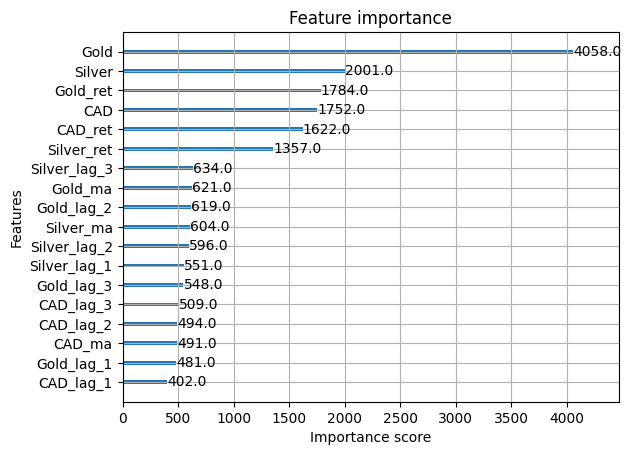

In [16]:
xgb.plot_importance(bst)

In [17]:
actual_gold  = y_test['Gold_target'].to_numpy()
actual_silver = y_test['Silver_target'].to_numpy()
actual_cad = y_test['CAD_target'].to_numpy()

In [18]:
# persistence baseline
baseline_gold  = np.roll(actual_gold, 1)
baseline_silver = np.roll(actual_silver, 1)
baseline_cad    = np.roll(actual_cad, 1)

baseline_gold[0] = actual_gold[0]
baseline_silver[0] = actual_silver[0]
baseline_cad[0] = actual_cad[0]

In [19]:
gold_pred = y_pred[:, 0]
silver_pred = y_pred[:, 1]
cad_pred = y_pred[:, 2]

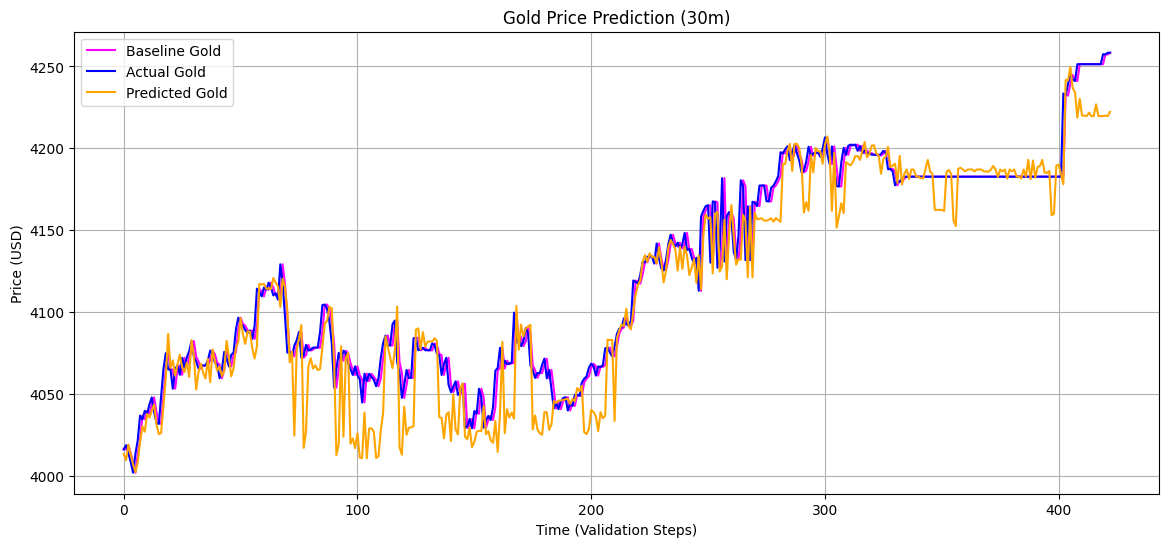

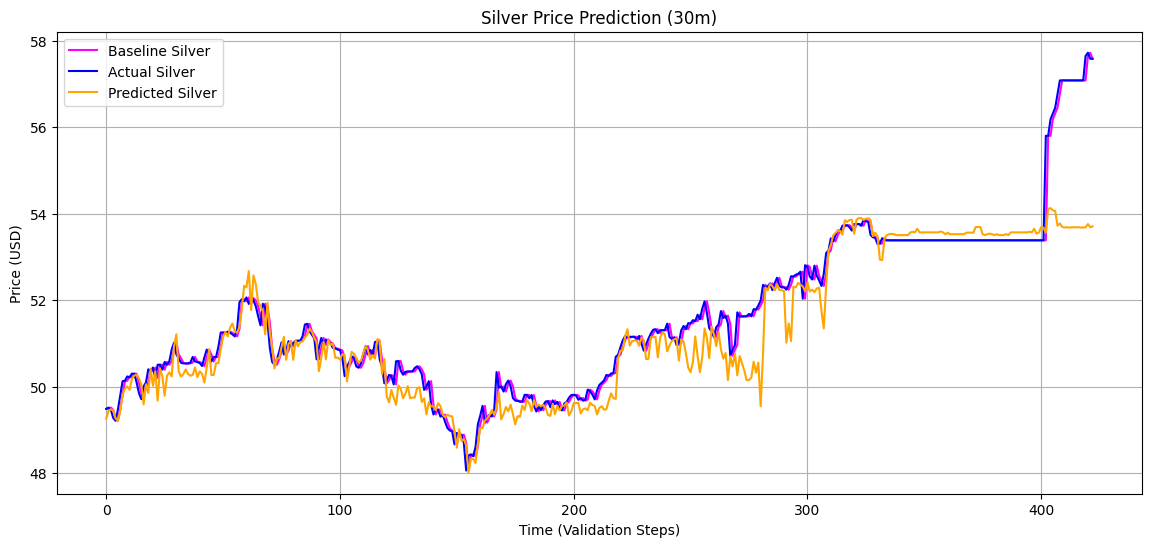

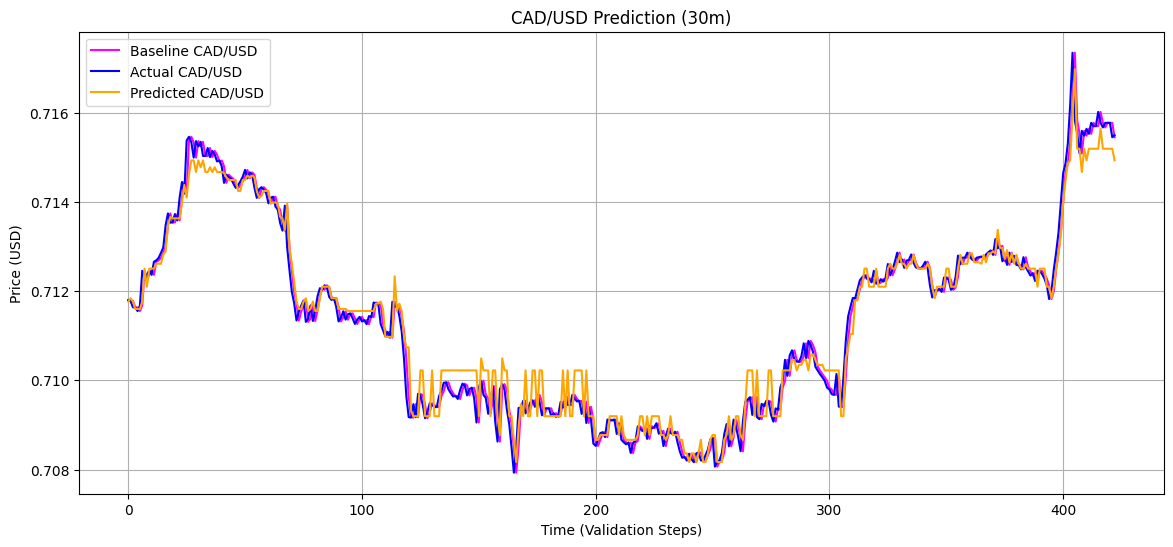

In [20]:
# gold
plt.figure(figsize=(14,6))
plt.plot(baseline_gold, color="magenta", label="Baseline Gold")
plt.plot(actual_gold, color="blue", label="Actual Gold")
plt.plot(gold_pred, color="orange", label="Predicted Gold")
plt.title("Gold Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# silver
plt.figure(figsize=(14,6))
plt.plot(baseline_silver, color="magenta", label="Baseline Silver")
plt.plot(actual_silver, color="blue", label="Actual Silver")
plt.plot(silver_pred, color="orange", label="Predicted Silver")
plt.title("Silver Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# CAD
plt.figure(figsize=(14,6))
plt.plot(baseline_cad, color="magenta", label="Baseline CAD/USD")
plt.plot(actual_cad, color="blue", label="Actual CAD/USD")
plt.plot(cad_pred, color="orange", label="Predicted CAD/USD")
plt.title("CAD/USD Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter Tuning

In [41]:
search_space = {
    'max_depth': Integer(3, 20),
    'learning_rate': Real(0.001, 1, prior='log-uniform'),
    'n_estimators': Integer (5, 30),
    'eval_metric': ['rmse', 'mae', 'mape']
}

In [42]:
n_train = int(len(X_train) * 0.70)
n_val = int(len(X_train) * 0.15)

train_indices = np.full(n_train, -1)
val_indices = np.zeros(n_val)

test_fold = np.concatenate([train_indices, val_indices])
from sklearn.model_selection import PredefinedSplit
ps = PredefinedSplit(test_fold)

In [43]:
opt = BayesSearchCV(
    XGBRegressor(tree_method="auto", random_state=42),
    search_space,
    n_iter=50,
    cv=ps,
    scoring='neg_mean_absolute_error',
    random_state=42
)

In [44]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,...
                                     n_jobs=None, num_parallel_tree=None, ...),
              random_state=42, scoring='neg_mean_absolute_error',
              search_spaces={'eval_metric': ['rmse', 'mae', 'mape'],
                             'learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=5, high=30, prior='uniform', transform='normalize')})

### Metrics Evaluation

In [45]:
best_params = opt.best_params_
best_params

OrderedDict([('eval_metric', 'rmse'),
             ('learning_rate', 0.1275465107211304),
             ('max_depth', 3),
             ('n_estimators', 30)])

In [46]:
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print('Mean Absolute Error :', mae)
print('Root Mean Squared Error :', rmse)
print('Mean Absolute Percentage Error :', mape)

Mean Absolute Error : 2.7640273571014404
Root Mean Squared Error : 6.490798599647168
Mean Absolute Percentage Error : 0.0027838728856295347


In [48]:
print("MAE:")
print("Gold  :", mean_absolute_error(y_test['Gold_target'], y_pred[:,0]))
print("Silver:", mean_absolute_error(y_test['Silver_target'], y_pred[:,1]))
print("CAD   :", mean_absolute_error(y_test['CAD_target'], y_pred[:,2]))

print("RMSE:")
print("Gold  :", np.sqrt(mean_squared_error(y_test['Gold_target'], y_pred[:,0])))
print("Silver:", np.sqrt(mean_squared_error(y_test['Silver_target'], y_pred[:,1])))
print("CAD   :", np.sqrt(mean_squared_error(y_test['CAD_target'], y_pred[:,2])))

print("MAPE:")
print("Gold  :", mean_absolute_percentage_error(y_test['Gold_target'], y_pred[:,0]))
print("Silver:", mean_absolute_percentage_error(y_test['Silver_target'], y_pred[:,1]))
print("CAD   :", mean_absolute_percentage_error(y_test['CAD_target'], y_pred[:,2]))

MAE:
Gold  : 7.964492256759752
Silver: 0.3273394519273832
CAD   : 0.00024958662952937133
RMSE:
Gold  : 11.217217297505563
Silver: 0.7520584066258501
CAD   : 0.00034012142018385606
MAPE:
Gold  : 0.0019282139305762658
Silver: 0.0060724406004582735
CAD   : 0.0003509518133675163


In [49]:
actual_gold  = y_test['Gold_target'].to_numpy()
actual_silver = y_test['Silver_target'].to_numpy()
actual_cad = y_test['CAD_target'].to_numpy()

In [51]:
# persistence baseline
baseline_gold  = np.roll(actual_gold, 1)
baseline_silver = np.roll(actual_silver, 1)
baseline_cad    = np.roll(actual_cad, 1)

baseline_gold[0] = actual_gold[0]
baseline_silver[0] = actual_silver[0]
baseline_cad[0] = actual_cad[0]

In [52]:
gold_pred = y_pred[:, 0]
silver_pred = y_pred[:, 1]
cad_pred = y_pred[:, 2]

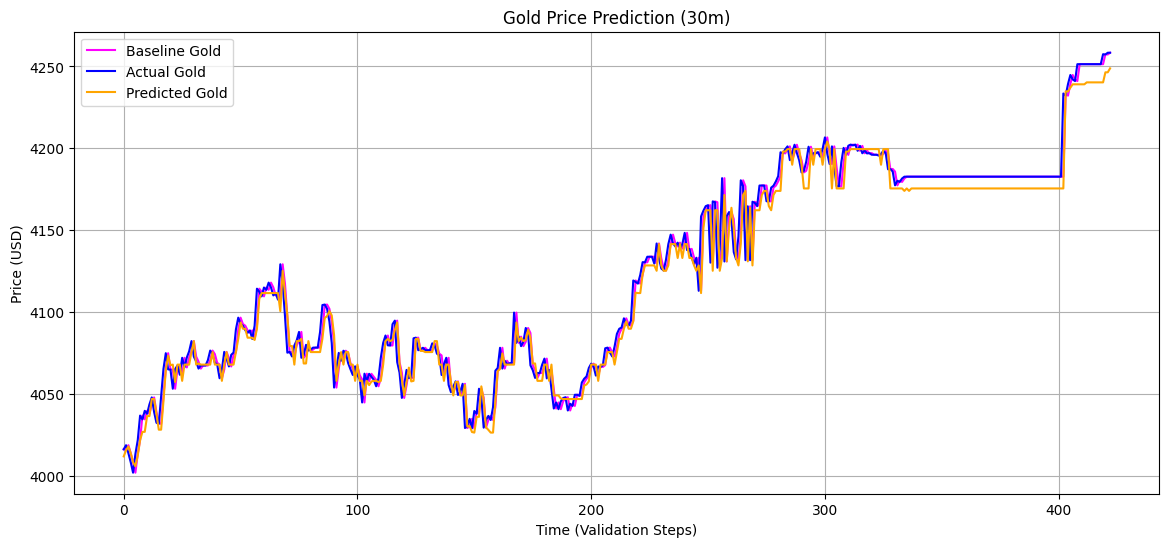

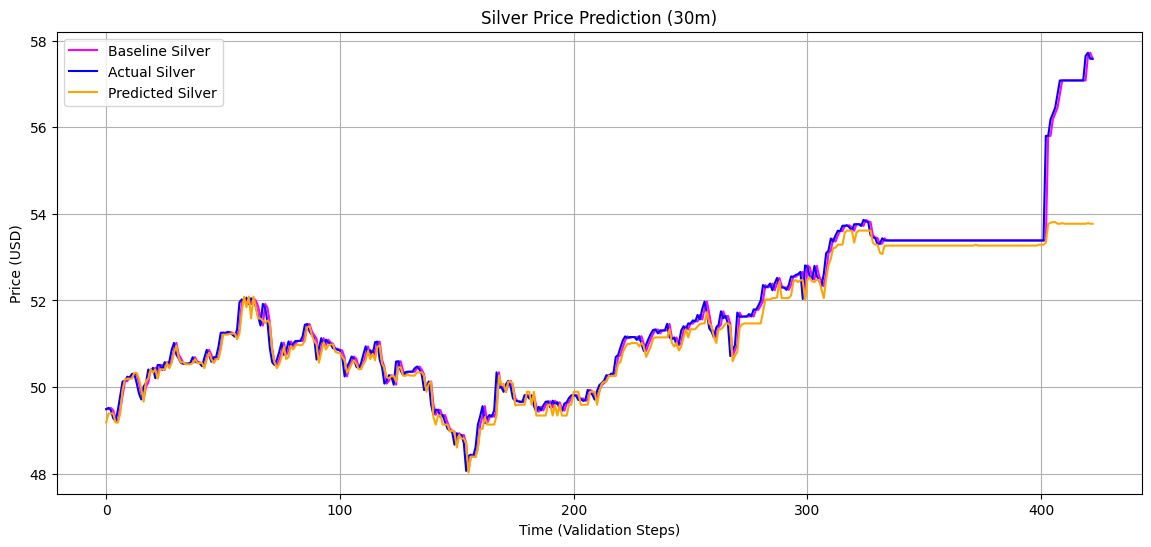

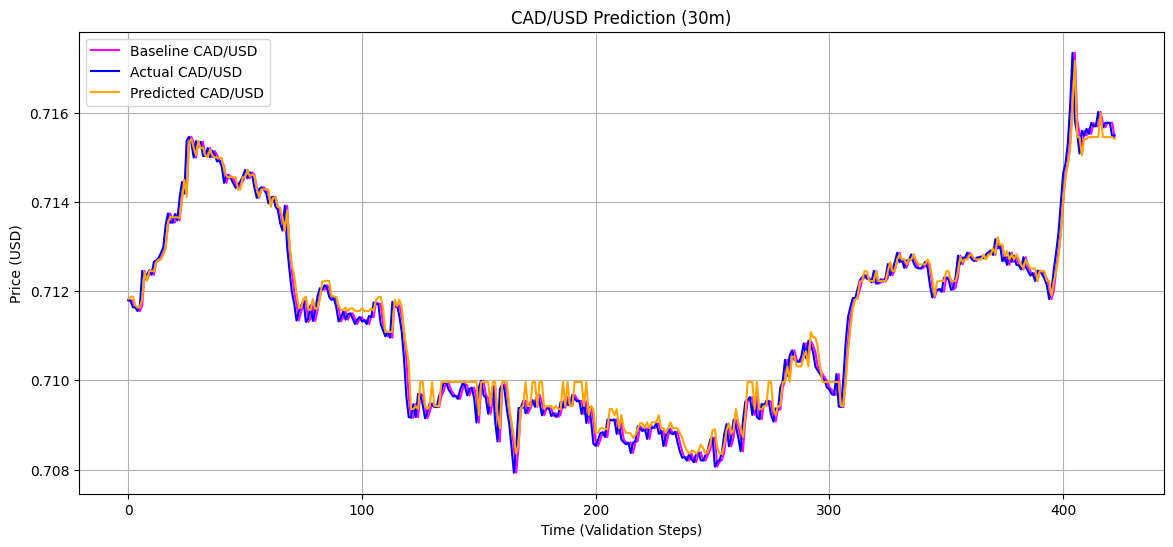

In [53]:
# gold
plt.figure(figsize=(14,6))
plt.plot(baseline_gold, color="magenta", label="Baseline Gold")
plt.plot(actual_gold, color="blue", label="Actual Gold")
plt.plot(gold_pred, color="orange", label="Predicted Gold")
plt.title("Gold Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# silver
plt.figure(figsize=(14,6))
plt.plot(baseline_silver, color="magenta", label="Baseline Silver")
plt.plot(actual_silver, color="blue", label="Actual Silver")
plt.plot(silver_pred, color="orange", label="Predicted Silver")
plt.title("Silver Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# CAD
plt.figure(figsize=(14,6))
plt.plot(baseline_cad, color="magenta", label="Baseline CAD/USD")
plt.plot(actual_cad, color="blue", label="Actual CAD/USD")
plt.plot(cad_pred, color="orange", label="Predicted CAD/USD")
plt.title("CAD/USD Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [63]:
best_model.save_model('xgboost_30m.json')
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1275465107211304, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=30, n_jobs=None,
             num_parallel_tree=None, ...)

# Future Predictions

In [82]:
params = XGBRegressor()
params.load_model('xgboost_30m.json')
params = params.get_xgb_params()
model = XGBRegressor(**params)

# Fit this new model on the entire dataset (X, y)
model.fit(X, y)
model

XGBRegressor(base_score=[3974.1174, 47.66643, 0.7165148], booster='gbtree',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [107]:
def forecast_interval(model, df, start_date, end_date):

    lag = 3
    window = 5

    historical_raw_data = df[['Gold', 'Silver', 'CAD']].iloc[-window:].copy()

    predictions = []
    future_index = pd.date_range(start=start_date, end=end_date, freq="30min")

    training_columns = X.columns.tolist()

    for _ in future_index:

        current_features_dict = {}

        current_gold = historical_raw_data['Gold'].iloc[-1]
        current_silver = historical_raw_data['Silver'].iloc[-1]
        current_cad = historical_raw_data['CAD'].iloc[-1]

        current_features_dict['Gold'] = current_gold
        current_features_dict['Silver'] = current_silver
        current_features_dict['CAD'] = current_cad

        # Returns (needs current and previous)
        prev_gold = historical_raw_data['Gold'].iloc[-2]
        prev_silver = historical_raw_data['Silver'].iloc[-2]
        prev_cad = historical_raw_data['CAD'].iloc[-2]

        current_features_dict['Gold_ret'] = (current_gold - prev_gold) / prev_gold if prev_gold != 0 else 0
        current_features_dict['Silver_ret'] = (current_silver - prev_silver) / prev_silver if prev_silver != 0 else 0
        current_features_dict['CAD_ret'] = (current_cad - prev_cad) / prev_cad if prev_cad != 0 else 0

        # Moving Averages (needs last 5 values)
        current_features_dict['Gold_ma'] = historical_raw_data['Gold'].rolling(window).mean().iloc[-1]
        current_features_dict['Silver_ma'] = historical_raw_data['Silver'].rolling(window).mean().iloc[-1]
        current_features_dict['CAD_ma'] = historical_raw_data['CAD'].rolling(window).mean().iloc[-1]

        for lag in range(1, lag + 1):
            current_features_dict[f"Gold_lag_{lag}"] = historical_raw_data['Gold'].iloc[-lag-1]
            current_features_dict[f"Silver_lag_{lag}"] = historical_raw_data['Silver'].iloc[-lag-1]
            current_features_dict[f"CAD_lag_{lag}"] = historical_raw_data['CAD'].iloc[-lag-1]

        X_input_df = pd.DataFrame([current_features_dict], columns=training_columns)
        X_input = X_input_df.values.reshape(1, -1)

        y_pred = model.predict(X_input)[0]

        predictions.append(y_pred)

        historical_raw_data = historical_raw_data.iloc[1:].copy()

        new_pred_row = pd.DataFrame([y_pred], columns=['Gold', 'Silver', 'CAD'])
        historical_raw_data = pd.concat([historical_raw_data, new_pred_row], ignore_index=True)

    pred_df = pd.DataFrame(predictions, index=future_index, columns=df[['Gold', 'Silver', 'CAD']].columns)
    return pred_df

In [110]:
future_start = "2025-12-1"
future_end   = "2025-12-2"

forecast_df = forecast_interval(model, all_prices, future_start, future_end)
forecast_df

,Gold,Silver,CAD
2025-12-01 00:00:00,4257.260254,57.574627,0.715339
2025-12-01 00:30:00,4258.374512,57.440418,0.715188
2025-12-01 01:00:00,4252.093750,57.525288,0.715124
2025-12-01 01:30:00,4251.368164,56.803867,0.715031
2025-12-01 02:00:00,4251.936035,56.808109,0.714970
2025-12-01 02:30:00,4254.677246,56.058392,0.715031
2025-12-01 03:00:00,4252.558594,56.986248,0.714970
2025-12-01 03:30:00,4259.250977,56.030148,0.715031
2025-12-01 04:00:00,4251.737793,57.074108,0.714970
2025-12-01 04:30:00,4258.653320,55.659267,0.715031


### Comparing predictions with actual prices

In [124]:
actual = pd.read_csv('/content/drive/MyDrive/ml-datasets/currencies_prediction/prices_30m.csv') #loaded today's prices
actual

,Datetime,Gold,Silver,CAD
0,2025-11-30 23:00:00+00:00,4257.500000,57.645000,0.715446
1,2025-11-30 23:30:00+00:00,4257.299805,57.720001,0.715446
2,2025-12-01 00:00:00+00:00,4262.299805,57.775002,0.715446
3,2025-12-01 00:30:00+00:00,4267.200195,58.060001,0.715553
4,2025-12-01 01:00:00+00:00,4274.700195,58.130001,0.716178
5,2025-12-01 01:30:00+00:00,4290.600098,58.564999,0.715753
6,2025-12-01 02:00:00+00:00,4276.299805,58.235001,0.715359
7,2025-12-01 02:30:00+00:00,4277.799805,58.139999,0.715262
8,2025-12-01 03:00:00+00:00,4269.700195,57.645000,0.715348
9,2025-12-01 03:30:00+00:00,4273.799805,57.950001,0.715308


In [120]:
actual_gold  = actual['Gold']#.to_numpy()
actual_silver = actual['Silver']#.to_numpy()
actual_cad = actual['CAD']#.to_numpy()

In [121]:
# persistence baseline
baseline_gold  = np.roll(actual_gold, 1)
baseline_silver = np.roll(actual_silver, 1)
baseline_cad    = np.roll(actual_cad, 1)

baseline_gold[0] = actual_gold[0]
baseline_silver[0] = actual_silver[0]
baseline_cad[0] = actual_cad[0]

In [122]:
gold_pred = forecast_df['Gold']
silver_pred = forecast_df['Silver']
cad_pred = forecast_df['CAD']

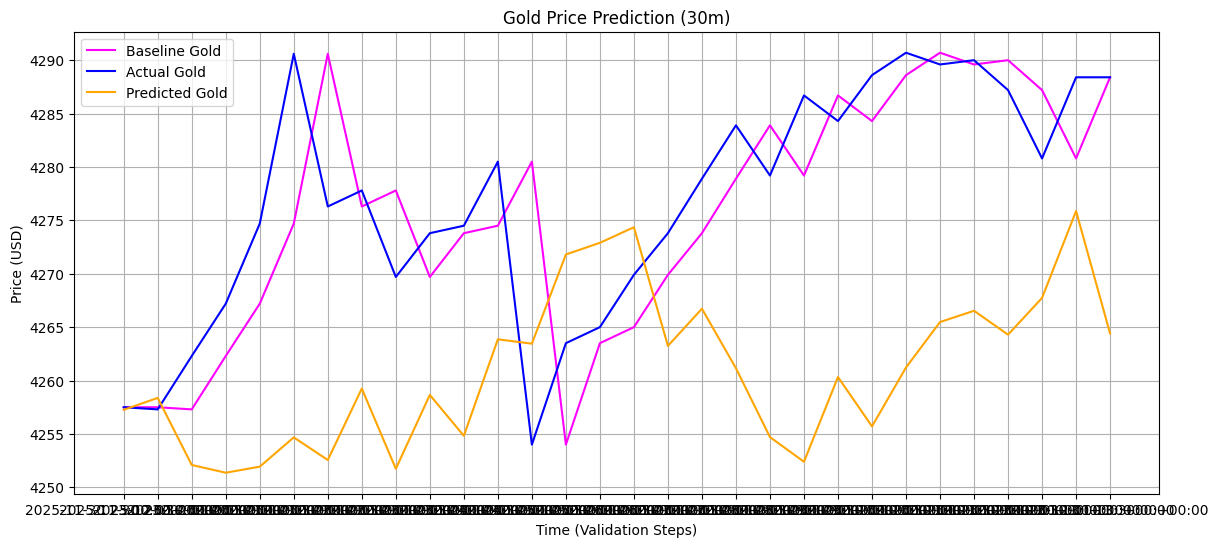

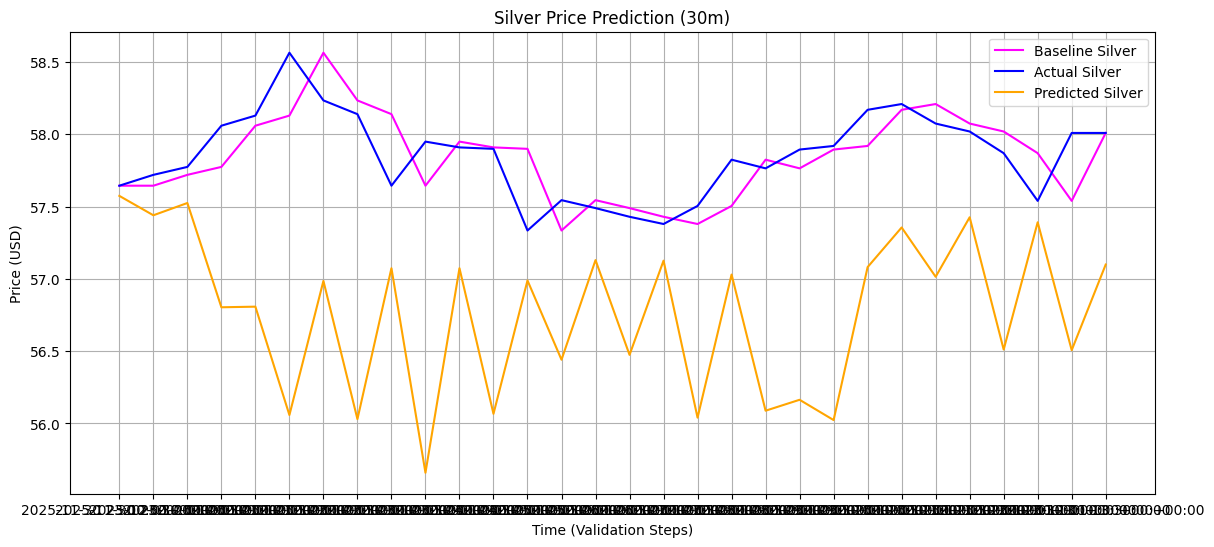

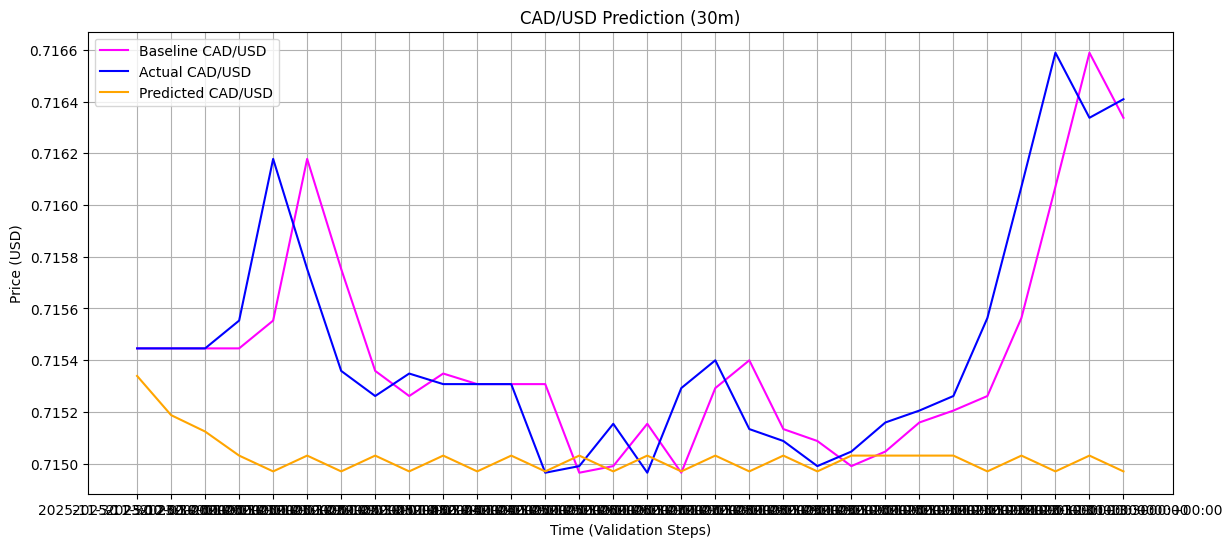

In [128]:
# gold
plt.figure(figsize=(14,6))
plt.plot(actual['Datetime'], baseline_gold, color="magenta", label="Baseline Gold")
plt.plot(actual['Datetime'], actual_gold, color="blue", label="Actual Gold")
plt.plot(actual['Datetime'], gold_pred.iloc[:len(actual['Datetime'])], color="orange", label="Predicted Gold")
plt.title("Gold Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# silver
plt.figure(figsize=(14,6))
plt.plot(actual['Datetime'], baseline_silver, color="magenta", label="Baseline Silver")
plt.plot(actual['Datetime'], actual_silver, color="blue", label="Actual Silver")
plt.plot(actual['Datetime'], silver_pred.iloc[:len(actual['Datetime'])], color="orange", label="Predicted Silver")
plt.title("Silver Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# CAD
plt.figure(figsize=(14,6))
plt.plot(actual['Datetime'], baseline_cad, color="magenta", label="Baseline CAD/USD")
plt.plot(actual['Datetime'], actual_cad, color="blue", label="Actual CAD/USD")
plt.plot(actual['Datetime'], cad_pred.iloc[:len(actual['Datetime'])], color="orange", label="Predicted CAD/USD")
plt.title("CAD/USD Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [134]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

actual_numerical = actual[['Gold', 'Silver', 'CAD']]

mae = mean_absolute_error(actual_numerical, forecast_df[:len(actual_numerical)])
rmse = np.sqrt(mean_squared_error(actual_numerical, forecast_df[:len(actual_numerical)]))
mape = mean_absolute_percentage_error(actual_numerical, forecast_df[:len(actual_numerical)])

print('Mean Absolute Error :', mae)
print('Root Mean Squared Error :', rmse)
print('Mean Absolute Percentage Error :', mape)

Mean Absolute Error : 6.34709872868326
Root Mean Squared Error : 11.650962901303965
Mean Absolute Percentage Error : 0.007860141298300533


In [140]:
print("MAE:")
print("Gold  :", mean_absolute_error(actual_numerical['Gold'], forecast_df[:len(actual_numerical)]['Gold']))
print("Silver:", mean_absolute_error(actual_numerical['Silver'], forecast_df[:len(actual_numerical)]['Silver']))
print("CAD   :", mean_absolute_error(actual_numerical['CAD'], forecast_df[:len(actual_numerical)]['CAD']))

print("RMSE:")
print("Gold  :", np.sqrt(mean_squared_error(actual_numerical['Gold'], forecast_df[:len(actual_numerical)]['Gold'])))
print("Silver:", np.sqrt(mean_squared_error(actual_numerical['Silver'], forecast_df[:len(actual_numerical)]['Silver'])))
print("CAD   :", np.sqrt(mean_squared_error(actual_numerical['CAD'], forecast_df[:len(actual_numerical)]['CAD'])))

print("MAPE:")
print("Gold  :", mean_absolute_percentage_error(actual_numerical['Gold'], forecast_df[:len(actual_numerical)]['Gold']))
print("Silver:", mean_absolute_percentage_error(actual_numerical['Silver'], forecast_df[:len(actual_numerical)]['Silver']))
print("CAD   :", mean_absolute_percentage_error(actual_numerical['CAD'], forecast_df[:len(actual_numerical)]['CAD']))

MAE:
Gold  : 17.951839192708334
Silver: 1.089030329386393
CAD   : 0.0004266639550526937
RMSE:
Gold  : 20.14007320491609
Silver: 1.2697482061039036
CAD   : 0.0006135151091653334
MAPE:
Gold  : 0.00419316629462717
Silver: 0.018791265249271372
CAD   : 0.0005959923510030524
